# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] I could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from my analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect("/amazon fine food reviews/database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

<div class="alert alert-block alert-danger">
From the above result, we can see that data is imbalanced (Positive Reviews > Negative Reviews)

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that deduplication is finished for our data and requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_4900)

Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.<br /><br />Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.<br /><br />Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.<br /><br />I use this as my SWEETENER in baking: cheesecakes, white brownies, muffins, pumpkin pies, etc... Unbelievably delicious...<br /><br />Can you tell I like it? :)


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_1500 = re.sub("\S*\d\S*", "", sent_1500).strip()
print(sent_1500)

Great ingredients although, chicken should have been  rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late  is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Can t do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this product br br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbage br br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrup br br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably delicious br br Can you tell I like it 


In [21]:
# https://gist.github.com/sebleier/554280
# removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, "br" is present in reviews
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above preprocessing steps 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:33<00:00, 2365.76it/s]


In [23]:
preprocessed_reviews[4900]

'ca not sugar tried scores sf syrups none touch excellence product thick delicious perfect ingredients water maltitol natural maple flavor period no chemicals no garbage numerous friends family members hooked stuff husband son not like sugar free prefer major label regular syrup use sweetener baking cheesecakes white brownies muffins pumpkin pies etc unbelievably delicious tell like'

<h2>[3.2] Preprocessing Review Summary</h2>

In [24]:
preprocessed_summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summaries.append(sentance.strip())

  0%|                                                                           | 343/364171 [00:00<01:47, 3395.95it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▍                                                                    | 22357/364171 [00:06<01:43, 3311.52it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
  6%|████▌                                                                    | 22697/364171 [00:06<01:42, 3327.75it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'COOKIES'" looks like a filename, not markup. You should probably open this file and pass the filehand

 41%|█████████████████████████████▌                                          | 149828/364171 [00:45<01:03, 3353.22it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 42%|██████████████████████████████▏                                         | 152517/364171 [00:46<01:06, 3161.49it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'cookies'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 55%|███████████████████████████████████████▉                                | 201893/364171 [01:01<00:48, 3378.88it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Cookies'" looks like a filename, not markup. You should probably open this file and pass the fi

 92%|██████████████████████████████████████████████████████████████████▍     | 335920/364171 [01:41<00:08, 3223.42it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'cookies'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 96%|█████████████████████████████████████████████████████████████████████▍  | 350939/364171 [01:45<00:03, 3481.33it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'Favorites'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 97%|██████████████████████████████████████████████████████████████████████  | 354660/364171 [01:46<00:02, 3255.56it/s]C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the fi

## Splitting Data - Train(70%) & Test(30%)

Source: __https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6__
![](https://miro.medium.com/max/1420/1*-8_kogvwmL1H6ooN1A1tsQ.png)

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.3, shuffle = False)

print("Total Reviews in Train set : ",len(x_train))
print("Total Reviews in Test set : ",len(x_test))

Total Reviews in Train set :  254919
Total Reviews in Test set :  109252


# [4] Featurization

## [4.1] BAG OF WORDS

Reference : 
1. __https://en.wikipedia.org/wiki/Bag-of-words_model#Example_implementation__
2. __http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html__

## [4.2] Bi-Grams and n-Grams.

Reference : __https://en.wikipedia.org/wiki/Bag-of-words_model#n-gram_model__

In [26]:
#bi-gram
#removing stop words like "not" should be avoided before building n-grams

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
bigrams_train = (count_vect.fit_transform(x_train))
bigrams_test = (count_vect.transform(x_test))
print("some feature names ", count_vect.get_feature_names()[300:310])
print('='*50)

print("the type of count vectorizer ",type(bigrams_train))
print("the shape of out text BOW vectorizer for Train set ",bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text BOW vectorizer for Test set ",bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", bigrams_test.get_shape()[1])                                              

some feature names  ['according product', 'according research', 'according reviews', 'according taste', 'according vet', 'according website', 'according wikipedia', 'accordingly', 'account', 'accounting']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for Train set  (254919, 141856)
the number of unique words including both unigrams and bigrams in Train set  141856
the shape of out text BOW vectorizer for Test set  (109252, 141856)
the number of unique words including both unigrams and bigrams Test set  141856


## [4.3] TF-IDF

Reference : 
1. __https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Definition__
2. __https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html__

In [27]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_bigrams_train = (tfidf_vect.fit_transform(x_train))
tfidf_bigrams_test = (tfidf_vect.transform(x_test))
print("some feature names ", tfidf_vect.get_feature_names()[2564:2574])
print('='*50)

print("the type of count vectorizer ",type(tfidf_bigrams_train))
print("the shape of out text BOW vectorizer for Train set ",tfidf_bigrams_train.get_shape())
print("the number of unique words including both unigrams and bigrams in Train set ", tfidf_bigrams_train.get_shape()[1])
print('='*50)                                             
print("the shape of out text BOW vectorizer for Test set ",tfidf_bigrams_test.get_shape())
print("the number of unique words including both unigrams and bigrams Test set ", tfidf_bigrams_test.get_shape()[1]) 

some feature names  ['along new', 'along not', 'along one', 'along others', 'along regular', 'along several', 'along side', 'along small', 'along snack', 'along tea']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer for Train set  (254919, 141856)
the number of unique words including both unigrams and bigrams in Train set  141856
the shape of out text BOW vectorizer for Test set  (109252, 141856)
the number of unique words including both unigrams and bigrams Test set  141856


## [4.4] Word2Vec

In [28]:
# Train our own Word2Vec model using preprocessed reviews
sentancesListTrain=[]
for eachSentance in x_train:
    sentancesListTrain.append(eachSentance.split())
sentancesListTest=[]
for eachSentance in x_test:
    sentancesListTest.append(eachSentance.split())

Reference: 

1. __https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92__
2. __https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/__


![](https://miro.medium.com/max/1080/1*HmmFCZpKk3i4EvMYZ855tg.png)

In [29]:
w2v_model=Word2Vec(sentancesListTrain,min_count=5,size=100, workers=-1)
print(w2v_model.wv.most_similar('excellent'))
print('='*50)
print(w2v_model.wv.most_similar('terrible'))

[('progressed', 0.38453409075737), ('hahah', 0.37714964151382446), ('sticker', 0.36509525775909424), ('partanna', 0.3584854006767273), ('whoppers', 0.3583081364631653), ('flavour', 0.3496069312095642), ('eric', 0.34663087129592896), ('boys', 0.34328222274780273), ('slimmed', 0.3377944529056549), ('whenver', 0.3371622562408447)]
[('fop', 0.35929927229881287), ('highways', 0.352065771818161), ('supernatural', 0.34527507424354553), ('adopted', 0.34330254793167114), ('trail', 0.3409535884857178), ('intersting', 0.3358910381793976), ('pvc', 0.33382514119148254), ('reproducing', 0.3334481716156006), ('fluffiest', 0.3296164572238922), ('buffy', 0.32900652289390564)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words : ", w2v_words[840:850])

number of words that occured minimum 5 times  28594
sample words :  ['account', 'couple', 'needs', 'value', 'loaded', 'chemical', 'fillers', 'irregular', 'drawback', 'surprising']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# computing average word2vec for each review.
trainWord2Vectors = [] # the avg-w2v for each train sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTrain): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length 100
    validWordCounts =0 # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words:
            vector = w2v_model.wv[eachWord]
            sentanceVector += vector
            validWordCounts += 1
    if validWordCounts != 0:
        sentanceVector /= validWordCounts
    trainWord2Vectors.append(sentanceVector)
print(len(trainWord2Vectors))
print(len(trainWord2Vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [20:23<00:00, 208.33it/s]


254919
100


In [32]:
testWord2Vectors = []; # the avg-w2v for each test sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTest): 
    sentanceVector = np.zeros(100)
    validWordCounts =0
    for eachWord in eachSentance: 
        if eachWord in w2v_words:
            vector = w2v_model.wv[eachWord]
            sentanceVector += vector
            validWordCounts += 1
    if validWordCounts != 0:
        sentanceVector /= validWordCounts
    testWord2Vectors.append(sentanceVector)
print(len(testWord2Vectors))
print(len(testWord2Vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [09:00<00:00, 202.15it/s]


109252
100


#### [4.4.1.2] TFIDF weighted W2v

In [33]:
tfidfW2VModel = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidfW2VModelVectors = tfidfW2VModel.fit_transform(x_train)
# creating hashmap with word as key and inverse document frequency as value
wordsHashMap = dict(zip(tfidfW2VModel.get_feature_names(), list(tfidfW2VModel.idf_)))

In [34]:
# TF-IDF weighted Word2Vec
tfidfWords = tfidfW2VModel.get_feature_names() # tfidf words

trainTfidfWord2Vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTrain): 
    sentanceVector = np.zeros(100) # as word vectors are of 100 length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    trainTfidfWord2Vectors.append(sentanceVector)

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [34:38<00:00, 122.63it/s]


In [35]:
print(len(trainTfidfWord2Vectors))
print(len(trainTfidfWord2Vectors[0]))

254919
100


In [36]:
testTfidfWord2Vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTest): 
    sentanceVector = np.zeros(100) # as word vectors are of 100 length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    testTfidfWord2Vectors.append(sentanceVector)
print(len(testTfidfWord2Vectors))
print(len(testTfidfWord2Vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 109252/109252 [16:59<00:00, 107.17it/s]


109252
100


# ENSEMBLES

In [37]:
#source - 
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
def gridSearcher(model,parameters,inputs,outputs):
    clf = GridSearchCV(model,
                       param_grid = parameters,
                       return_train_score = True,
                       scoring='roc_auc',
                       n_jobs=-1,
                       cv=5)
    clf.fit(inputs,outputs)
    return clf

In [38]:
#source - https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sns

def plotAUCvsHyperParam(model):
    plt.figure(figsize=(10,10))
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
    
    testScore = model.cv_results_["mean_test_score"]
    testScore = testScore.reshape(len(model.param_grid["max_depth"]),len(model.param_grid["n_estimators"]))
    g1 = sns.heatmap(testScore, 
                     annot = True,
                     fmt=".4f",
                     ax = ax1,
                     cmap = sns.color_palette("Paired"),
                     xticklabels=model.param_grid["n_estimators"],
                     yticklabels=model.param_grid["max_depth"])
    g1.set_xlabel("n_estimators") 
    g1.set_ylabel("max_depth")
    title = "Best Cross Validation Score = "+\
            str(model.best_score_)+"\n"\
            " at "+\
            "max_depth "+str(model.best_params_["max_depth"])+\
            " , "+\
            "n_estimators "+str(model.best_params_["n_estimators"])
    ax1.title.set_text(title)
    ax1.title.set_fontsize(15)
    
    trainScore = model.cv_results_["mean_train_score"]
    trainScore = trainScore.reshape(len(model.param_grid["max_depth"]),len(model.param_grid["n_estimators"]))
    indices = np.unravel_index(np.argmax(trainScore, axis=None), trainScore.shape)
    g2 = sns.heatmap(trainScore, 
                     annot = True,
                     fmt=".4f",
                     ax = ax2,
                     cmap = sns.color_palette("Paired"),
                     xticklabels=model.param_grid["n_estimators"],
                     yticklabels=model.param_grid["max_depth"])
    g2.set_xlabel("n_estimators")
    g2.set_ylabel("max_depth")
    title = "Best Train Score = "+\
            str(trainScore.max())+"\n"\
            " at "+\
            "max_depth "+str(model.param_grid["max_depth"][indices[0]])+\
            " , "+\
            "n_estimators "+str(model.param_grid["n_estimators"][indices[1]])
    ax2.title.set_text(title)
    ax2.title.set_fontsize(15)

In [39]:
#source - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn import metrics
def rocCurve(model,trainData,trainLabels,testData,testLabels):
    predictedProbabilities = model.predict_proba(testData)
    fpr, tpr, thresholds = metrics.roc_curve(testLabels, predictedProbabilities[:,1])
    plt.plot(fpr,tpr,label='Test AUC is %0.3f' %(metrics.auc(fpr,tpr)))
    predictedProbabilities = model.predict_proba(trainData)
    fpr, tpr, thresholds = metrics.roc_curve(trainLabels, predictedProbabilities[:,1])
    plt.plot(fpr,tpr,label='Train AUC is %0.3f' %(metrics.auc(fpr,tpr)))
    plt.legend()
    plt.show()
    
    

In [40]:
#source - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix
def confusionMatrix(model,testData,testLabels):
    tn, fp, fn, tp = confusion_matrix(testLabels,model.predict(testData)).ravel()
    sns.heatmap([[tn,fp],[fn,tp]],yticklabels=["Actual 0","Actual 1"],\
                 xticklabels=["Predicted 0","Predicted 1"],annot = True,fmt='d')

# Applying Random Forest

## [5.1] Applying Random Forest on BOW

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf_bigram_model = gridSearcher(RandomForestClassifier(),
                               {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                               bigrams_train,
                               y_train)

Text(0.49, 1.1, 'Bag of Words - Bigram')

<Figure size 720x720 with 0 Axes>

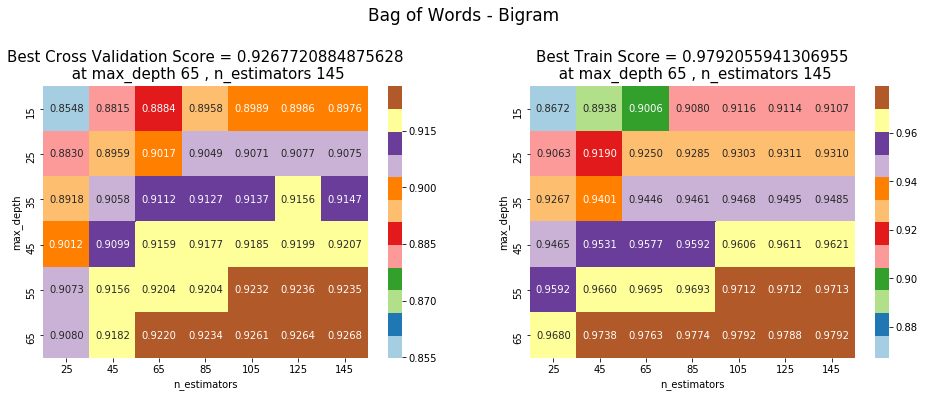

In [42]:
plotAUCvsHyperParam(rf_bigram_model)
plt.suptitle('Bag of Words - Bigram',fontsize=17,x=0.49,y = 1.1)

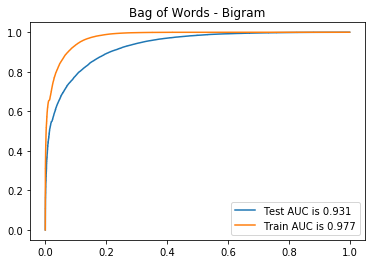

In [43]:
plt.title("Bag of Words - Bigram")
rocCurve(rf_bigram_model,bigrams_train,y_train,bigrams_test,y_test)

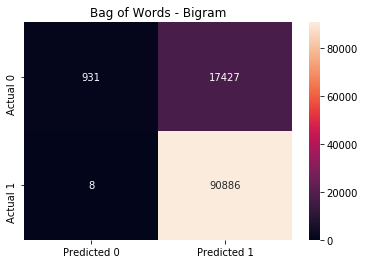

In [44]:
plt.title("Bag of Words - Bigram")
confusionMatrix(rf_bigram_model,bigrams_test,y_test)

### [5.1.1] Top 20 important features

In [45]:
df = pd.DataFrame(data = rf_bigram_model.best_estimator_.feature_importances_,index=count_vect.get_feature_names()).sort_values(by=0,ascending=False)

In [46]:
print("Top 20 Features")
print(df[:20])

Top 20 Features
                      0
great          0.011882
not            0.010903
not buy        0.009940
worst          0.008378
disappointed   0.007246
threw          0.007008
return         0.006909
waste          0.006349
waste money    0.006005
would not      0.006003
not recommend  0.005998
money          0.005985
horrible       0.005844
bad            0.005825
best           0.005439
not worth      0.005373
terrible       0.005208
disappointing  0.005093
awful          0.005000
love           0.004864


### [5.1.2] Top 20 important features - WordCloud

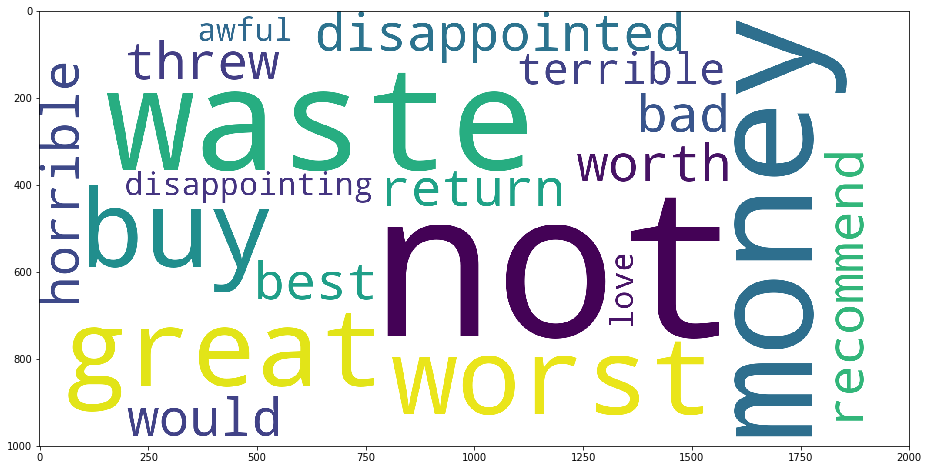

In [47]:
import wordcloud
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud.WordCloud(width = 2000, height = 1000, 
                                background_color ='white',
                                stopwords = stopwords).generate(' '.join(df.index.to_list()[:20])))

## [5.2] Applying Random Forest on TFIDF

In [48]:
rf_tfidf_bigram_model = gridSearcher(RandomForestClassifier(),
                                    {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                    tfidf_bigrams_train,
                                    y_train)

Text(0.49, 1.1, 'TfIdf - Bigram')

<Figure size 720x720 with 0 Axes>

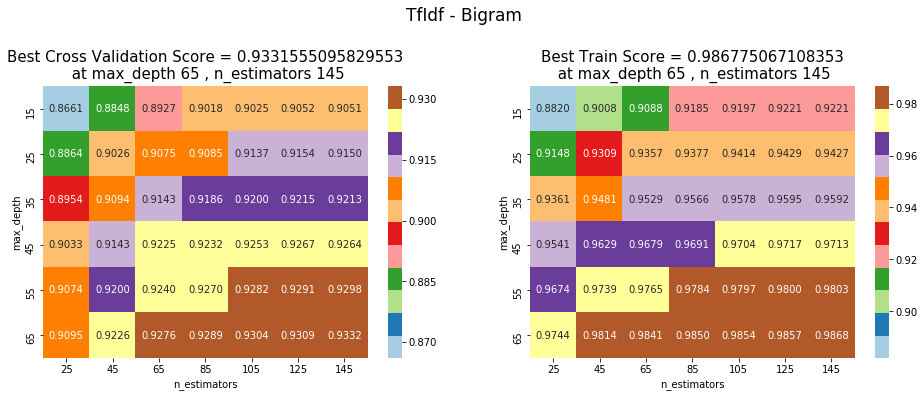

In [49]:
plotAUCvsHyperParam(rf_tfidf_bigram_model)
plt.suptitle('TfIdf - Bigram',fontsize=17,x=0.49,y = 1.1)

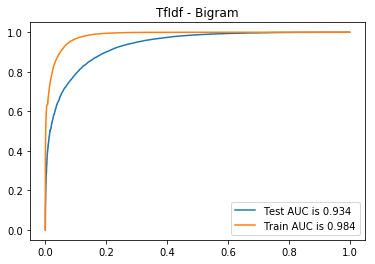

In [50]:
plt.title("TfIdf - Bigram")
rocCurve(rf_tfidf_bigram_model,tfidf_bigrams_train,y_train,tfidf_bigrams_test,y_test)

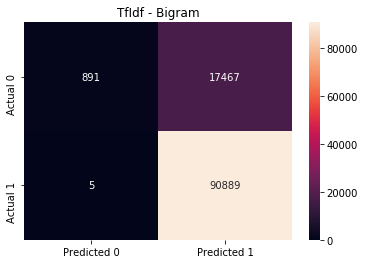

In [51]:
plt.title("TfIdf - Bigram")
confusionMatrix(rf_tfidf_bigram_model,tfidf_bigrams_test,y_test)

### [5.2.1] Top 20 important features

In [52]:
df = pd.DataFrame(data = rf_tfidf_bigram_model.best_estimator_.feature_importances_,index=tfidf_vect.get_feature_names()).sort_values(by=0,ascending=False)[0:20]

In [53]:
print("Top 20 Features")
print(df[:20])

Top 20 Features
                      0
not            0.016296
great          0.009719
disappointed   0.008904
not buy        0.008740
worst          0.008561
horrible       0.008382
return         0.007475
would not      0.006650
not worth      0.006397
waste money    0.006143
awful          0.006073
waste          0.006034
not recommend  0.005876
best           0.005742
terrible       0.005507
bad            0.005389
threw          0.005248
money          0.005204
refund         0.005186
disappointing  0.004956


### [5.2.2] Top 20 important features - WordCloud

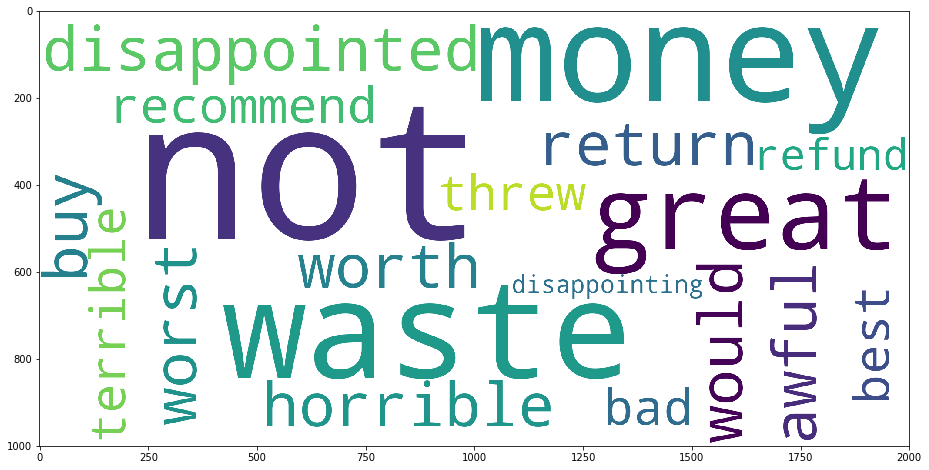

In [54]:
plt.figure(figsize = (16, 8), facecolor = None) 
plt.imshow(wordcloud.WordCloud(width = 2000, height = 1000, 
                                background_color ='white',
                                stopwords = stopwords).generate(' '.join(df.index.to_list()[:20])))

## [5.3] Applying Random Forest on AVG W2V

In [55]:
rf_avgW2v_model = gridSearcher(RandomForestClassifier(),
                               {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                               trainWord2Vectors,
                               y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706

Text(0.49, 1.1, 'Average Word2vec')

<Figure size 720x720 with 0 Axes>

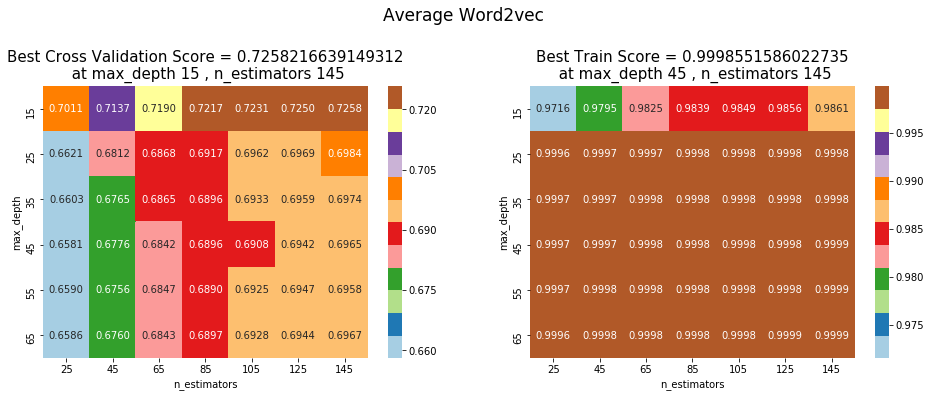

In [56]:
plotAUCvsHyperParam(rf_avgW2v_model)
plt.suptitle('Average Word2vec',fontsize=17,x=0.49,y = 1.1)

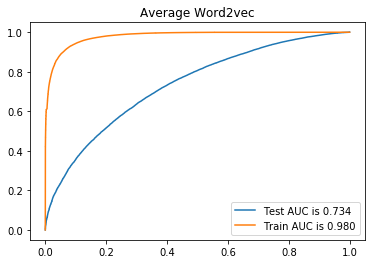

In [57]:
plt.title("Average Word2vec")
rocCurve(rf_avgW2v_model,trainWord2Vectors,y_train,testWord2Vectors,y_test)

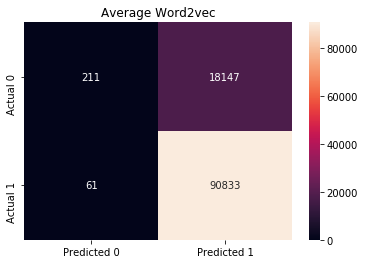

In [58]:
plt.title("Average Word2vec")
confusionMatrix(rf_avgW2v_model,testWord2Vectors,y_test)

## [5.4] Applying Random Forest on TFIDF W2V

In [59]:
rf_tfidfW2v_model = gridSearcher(RandomForestClassifier(),
                                 {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                 trainTfidfWord2Vectors,
                                 y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706

Text(0.49, 1.1, 'Tfidf Weighted Word2Vec')

<Figure size 720x720 with 0 Axes>

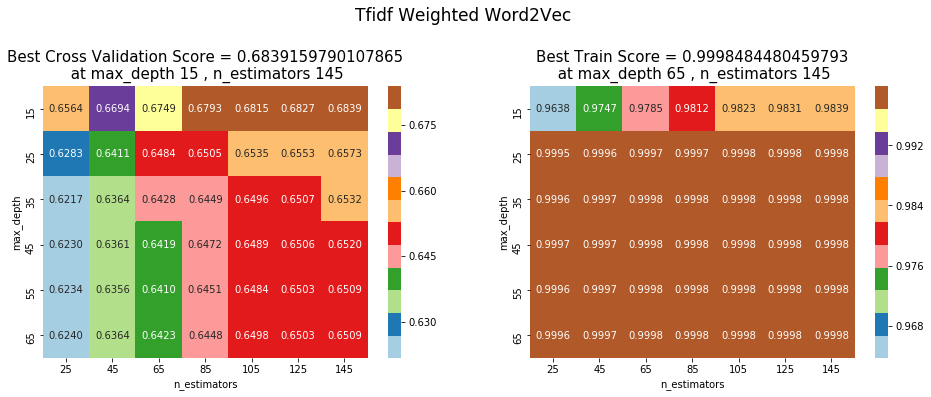

In [60]:
plotAUCvsHyperParam(rf_tfidfW2v_model)
plt.suptitle('Tfidf Weighted Word2Vec',fontsize=17,x=0.49,y = 1.1)

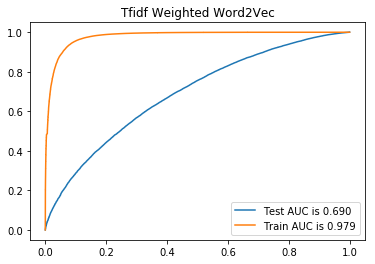

In [61]:
plt.title("Tfidf Weighted Word2Vec")
rocCurve(rf_tfidfW2v_model,trainTfidfWord2Vectors,y_train,testTfidfWord2Vectors,y_test)

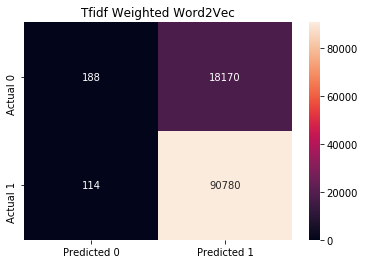

In [62]:
plt.title("Tfidf Weighted Word2Vec")
confusionMatrix(rf_tfidfW2v_model,testTfidfWord2Vectors,y_test)

# Applying XGBoost (Gradient Boost Decision Trees)

## [6.1] Applying XGBoost on BOW

In [63]:
from xgboost import XGBClassifier
gbdt_bigram_model = gridSearcher(XGBClassifier(),
                                 {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                 bigrams_train[:100000],
                                 y_train[:100000])

Text(0.49, 1.1, 'Bag of Words - Bigram')

<Figure size 720x720 with 0 Axes>

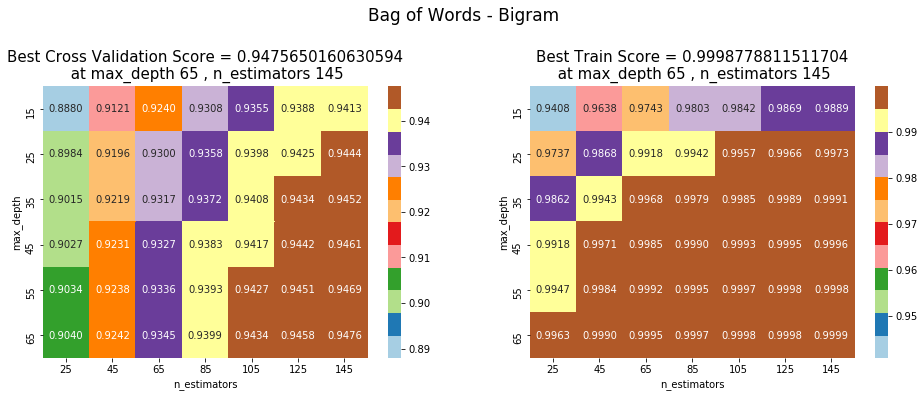

In [64]:
plotAUCvsHyperParam(gbdt_bigram_model)
plt.suptitle('Bag of Words - Bigram',fontsize=17,x=0.49,y = 1.1)

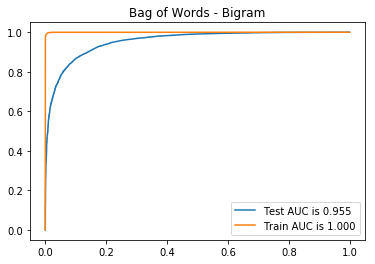

In [65]:
plt.title("Bag of Words - Bigram")
rocCurve(gbdt_bigram_model,bigrams_train[:100000],y_train[:100000],bigrams_test[:40000],y_test[:40000])

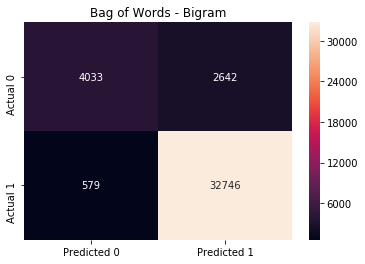

In [66]:
plt.title("Bag of Words - Bigram")
confusionMatrix(gbdt_bigram_model,bigrams_test[:40000],y_test[:40000])

## [6.2] Applying XGBoost on TFIDF

In [67]:
gbdt_tfidf_bigram_model = gridSearcher(XGBClassifier(),
                                       {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                       tfidf_bigrams_train[:100000],
                                       y_train[:100000])

Text(0.49, 1.1, 'TfIdf - Bigram')

<Figure size 720x720 with 0 Axes>

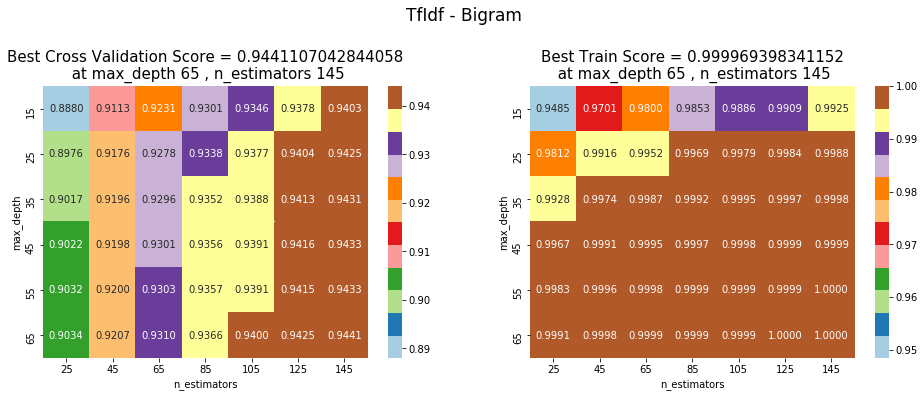

In [68]:
plotAUCvsHyperParam(gbdt_tfidf_bigram_model)
plt.suptitle('TfIdf - Bigram',fontsize=17,x=0.49,y = 1.1)

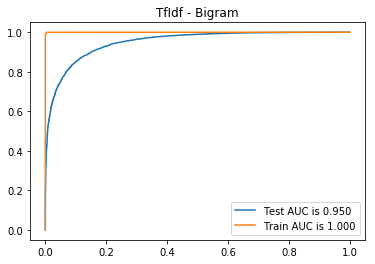

In [69]:
plt.title("TfIdf - Bigram")
rocCurve(gbdt_tfidf_bigram_model,tfidf_bigrams_train[:100000],y_train[:100000],tfidf_bigrams_test[:40000],y_test[:40000])

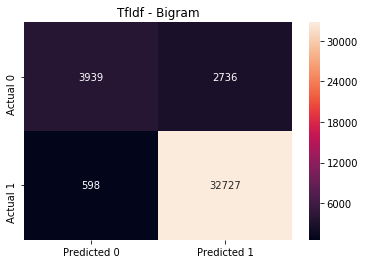

In [70]:
plt.title("TfIdf - Bigram")
confusionMatrix(gbdt_tfidf_bigram_model,tfidf_bigrams_test[:40000],y_test[:40000])

## [6.3] Applying XGBoost on AVG W2V

In [71]:
gbdt_avgW2v_model = gridSearcher(XGBClassifier(),
                                 {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                 np.asarray(trainWord2Vectors[:100000]),
                                 y_train[:100000])

Text(0.49, 1.1, 'Average Word2vec')

<Figure size 720x720 with 0 Axes>

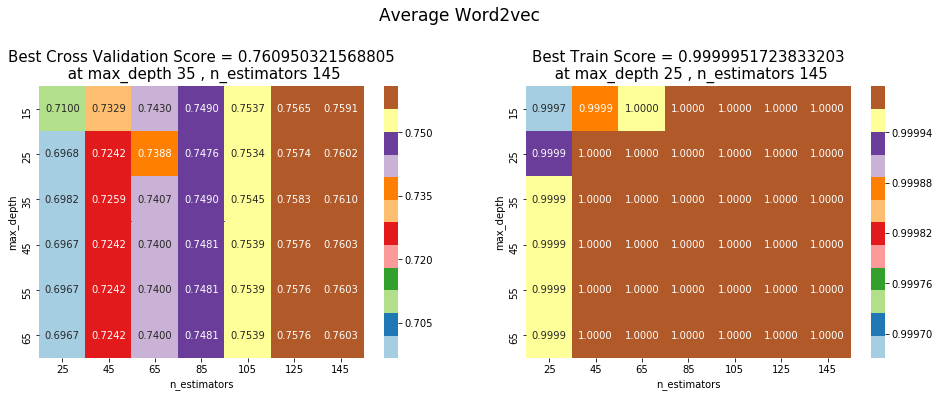

In [72]:
plotAUCvsHyperParam(gbdt_avgW2v_model)
plt.suptitle('Average Word2vec',fontsize=17,x=0.49,y = 1.1)

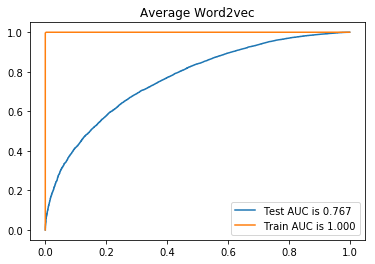

In [73]:
plt.title("Average Word2vec")
rocCurve(gbdt_avgW2v_model,
         np.asarray(trainWord2Vectors[:100000]),
         y_train[:100000],
         np.asarray(testWord2Vectors[:40000]),
         y_test[:40000])

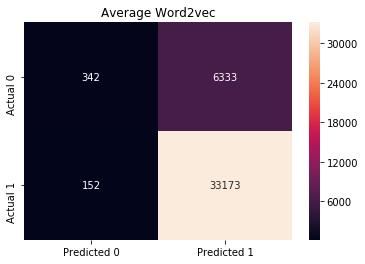

In [74]:
plt.title("Average Word2vec")
confusionMatrix(gbdt_avgW2v_model,np.asarray(testWord2Vectors[:40000]),y_test[:40000])

## [6.4] Applying Random Forest on TFIDF W2V

In [75]:
gbdt_tfidfW2v_model = gridSearcher(XGBClassifier(),
                                   {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                   np.asarray(trainTfidfWord2Vectors[:100000]),
                                   y_train[:100000])

Text(0.49, 1.1, 'Tfidf Weighted Word2Vec')

<Figure size 720x720 with 0 Axes>

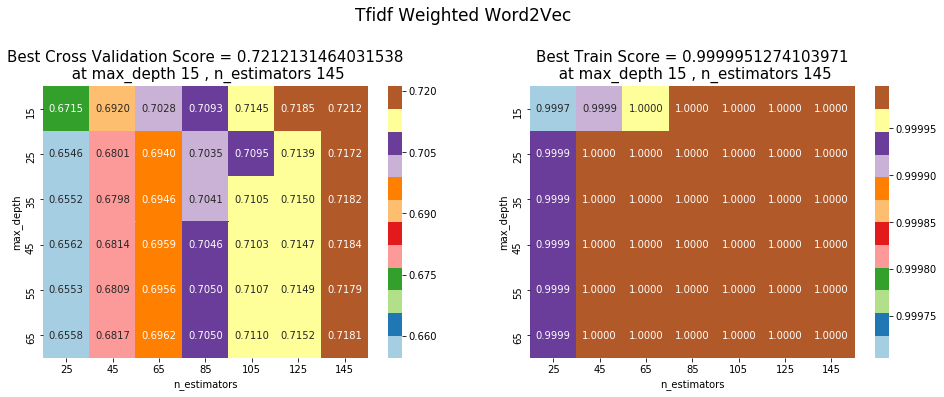

In [76]:
plotAUCvsHyperParam(gbdt_tfidfW2v_model)
plt.suptitle('Tfidf Weighted Word2Vec',fontsize=17,x=0.49,y = 1.1)

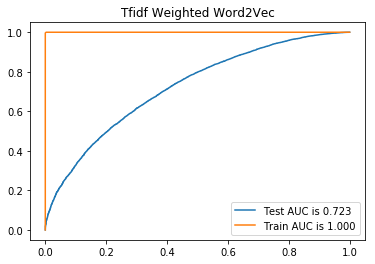

In [77]:
plt.title("Tfidf Weighted Word2Vec")
rocCurve(gbdt_tfidfW2v_model,
         np.asarray(trainTfidfWord2Vectors[:100000]),
         y_train[:100000],
         np.asarray(testTfidfWord2Vectors[:40000]),
         y_test[:40000])

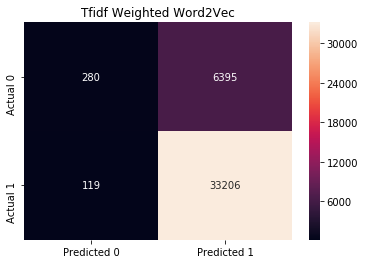

In [78]:
plt.title("Tfidf Weighted Word2Vec")
confusionMatrix(gbdt_tfidfW2v_model,np.asarray(testTfidfWord2Vectors[:40000]),y_test[:40000])

# [7] Feature Engineering

## [7.1] TfIdf Weighted W2V Vectorization

In [79]:
#appending each summary with each review text
reviewWithSummary = []
for eachReview,eachSummary in tqdm(zip(preprocessed_reviews,preprocessed_summaries)):
    reviewWithSummary.append(eachReview+" "+eachSummary)

364171it [00:00, 809276.52it/s]


In [80]:
print("length of feature engineered reviews :"+str(len(reviewWithSummary)))

length of feature engineered reviews :364171


In [81]:
x_train,x_test,y_train,y_test = train_test_split(reviewWithSummary,final['Score'],test_size = 0.3, shuffle = False)

In [82]:
tfidfW2VModel_FE = TfidfVectorizer(ngram_range=(1,1), min_df=10, max_features=5000)
tfidfW2VModelVectors_FE = tfidfW2VModel_FE.fit_transform(x_train)
# creating hashmap with word as key and inverse document frequency as value
wordsHashMap_FE = dict(zip(tfidfW2VModel_FE.get_feature_names(), list(tfidfW2VModel_FE.idf_)))

In [83]:
# Train our own Word2Vec model using preprocessed reviews
sentancesListTrain_FE=[]
for eachSentance in x_train:
    sentancesListTrain_FE.append(eachSentance.split())
sentancesListTest_FE=[]
for eachSentance in x_test:
    sentancesListTest_FE.append(eachSentance.split())

In [84]:
# TF-IDF weighted Word2Vec
tfidfWords_FE = tfidfW2VModel_FE.get_feature_names() # tfidf words

trainTfidfWord2Vectors_FE = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTrain_FE): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap_FE[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    trainTfidfWord2Vectors_FE.append(sentanceVector)

100%|█████████████████████████████████████████████████████████████████████████| 254919/254919 [39:52<00:00, 106.53it/s]


In [85]:
print(len(trainTfidfWord2Vectors_FE))
print(len(trainTfidfWord2Vectors_FE[0]))

254919
100


In [86]:
testTfidfWord2Vectors_FE = []; # the tfidf-w2v for each sentence/review is stored in this list
for eachSentance in tqdm(sentancesListTest_FE): 
    sentanceVector = np.zeros(100) # as word vectors are of zero length
    weightedSum =0; # num of words with a valid vector in the sentence/review
    for eachWord in eachSentance: 
        if eachWord in w2v_words and eachWord in tfidfWords:
            vector = w2v_model.wv[eachWord]
            tf_idf = wordsHashMap_FE[eachWord]*(eachSentance.count(eachWord)/len(eachSentance))
            sentanceVector += (vector * tf_idf)
            weightedSum += tf_idf
    if weightedSum != 0:
        sentanceVector /= weightedSum
    testTfidfWord2Vectors_FE.append(sentanceVector)
print(len(testTfidfWord2Vectors_FE))
print(len(testTfidfWord2Vectors_FE[0]))

100%|██████████████████████████████████████████████████████████████████████████| 109252/109252 [18:32<00:00, 98.25it/s]


109252
100


## [7.2] Applying XGBoost on Feature Engineered dataset

In [87]:
FE_gbdt_tfidfW2v_model = gridSearcher(XGBClassifier(),
                                   {"max_depth":[15,25,35,45,55,65], "n_estimators":[25,45,65,85,105,125,145]},
                                   np.asarray(trainTfidfWord2Vectors_FE[:100000]),
                                   y_train[:100000])

Text(0.49, 1.1, 'Tfidf Weighted Word2Vec(with summaries)')

<Figure size 720x720 with 0 Axes>

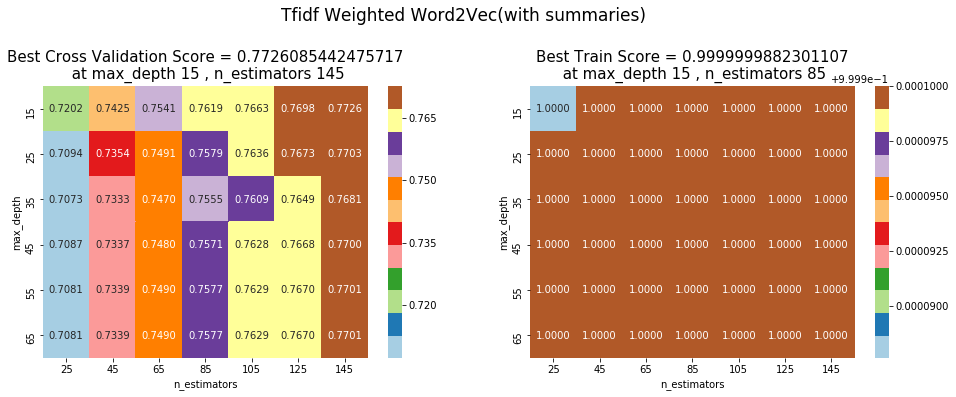

In [88]:
plotAUCvsHyperParam(FE_gbdt_tfidfW2v_model)
plt.suptitle('Tfidf Weighted Word2Vec(with summaries)',fontsize=17,x=0.49,y = 1.1)

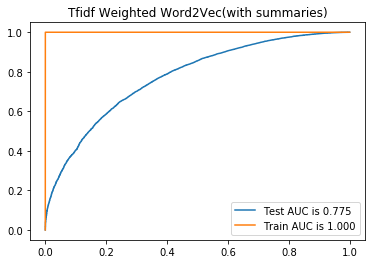

In [89]:
plt.title("Tfidf Weighted Word2Vec(with summaries)")
rocCurve(FE_gbdt_tfidfW2v_model,
         np.asarray(trainTfidfWord2Vectors_FE[:100000]),
         y_train[:100000],
         np.asarray(testTfidfWord2Vectors_FE[:40000]),
         y_test[:40000])

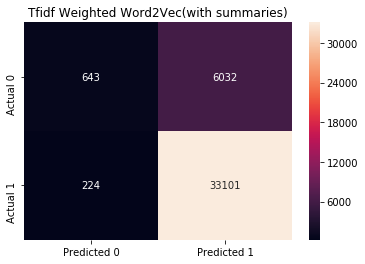

In [90]:
plt.title("Tfidf Weighted Word2Vec(with summaries)")
confusionMatrix(FE_gbdt_tfidfW2v_model,np.asarray(testTfidfWord2Vectors_FE[:40000]),y_test[:40000])

# [8] Conclusion

In [91]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectoriser","Parameters","Train AUC Score","Test AUC score"]
table.add_row(["Random Forest(BOW)",
               rf_bigram_model.best_params_,
               rf_bigram_model.score(bigrams_train,y_train),
               rf_bigram_model.score(bigrams_test,y_test)])
table.add_row(["Random Forest(TFIDF)",
               rf_tfidf_bigram_model.best_params_,
               rf_tfidf_bigram_model.score(tfidf_bigrams_train,y_train),
               rf_tfidf_bigram_model.score(tfidf_bigrams_test,y_test)])
table.add_row(["Random Forest (Avg W2V)",
               rf_avgW2v_model.best_params_,
               rf_avgW2v_model.score(trainWord2Vectors,y_train),
               rf_avgW2v_model.score(testWord2Vectors,y_test)])
table.add_row(["Random Forest (TFIDF W2V)",
               rf_tfidfW2v_model.best_params_,
               rf_tfidfW2v_model.score(trainTfidfWord2Vectors,y_train),
               rf_tfidfW2v_model.score(testTfidfWord2Vectors,y_test)])
table.add_row(["GBDT (BOW)",
               rf_bigram_model.best_params_,
               rf_bigram_model.score(bigrams_train,y_train),
               rf_bigram_model.score(bigrams_test,y_test)])
table.add_row(["GBDT (TFIDF)",
               rf_tfidf_bigram_model.best_params_,
               rf_tfidf_bigram_model.score(tfidf_bigrams_train,y_train),
               rf_tfidf_bigram_model.score(tfidf_bigrams_test,y_test)])
table.add_row(["GBDT (Avg W2V)",
               rf_avgW2v_model.best_params_,
               rf_avgW2v_model.score(np.asarray(trainWord2Vectors[:100000]),y_train[:100000]),
               rf_avgW2v_model.score(np.asarray(testWord2Vectors[:40000]),y_test[:40000])])
table.add_row(["GBDT (TFIDF W2V)",
               rf_tfidfW2v_model.best_params_,
               rf_tfidfW2v_model.score(np.asarray(trainTfidfWord2Vectors[:100000]),y_train[:100000]),
               rf_tfidfW2v_model.score(np.asarray(testTfidfWord2Vectors[:40000]),y_test[:40000])])
table.add_row(["GBDT (TFIDF W2V)"+"\n"+"(With Summary)",
               FE_gbdt_tfidfW2v_model.best_params_,
               FE_gbdt_tfidfW2v_model.score(np.asarray(trainTfidfWord2Vectors_FE[:100000]),y_train[:100000]),
               FE_gbdt_tfidfW2v_model.score(np.asarray(testTfidfWord2Vectors_FE[:40000]),y_test[:40000])])

In [92]:
print(table)

+---------------------------+----------------------------------------+--------------------+--------------------+
|         Vectoriser        |               Parameters               |  Train AUC Score   |   Test AUC score   |
+---------------------------+----------------------------------------+--------------------+--------------------+
|     Random Forest(BOW)    | {'max_depth': 65, 'n_estimators': 145} | 0.9769219702051666 | 0.9313069901404483 |
|    Random Forest(TFIDF)   | {'max_depth': 65, 'n_estimators': 145} | 0.9840452573364606 | 0.9343892298671965 |
|  Random Forest (Avg W2V)  | {'max_depth': 15, 'n_estimators': 145} | 0.9796778396345454 | 0.7338632789249574 |
| Random Forest (TFIDF W2V) | {'max_depth': 15, 'n_estimators': 145} | 0.9789776041070404 | 0.6900126718289838 |
|         GBDT (BOW)        | {'max_depth': 65, 'n_estimators': 145} | 0.9769219702051666 | 0.9313069901404483 |
|        GBDT (TFIDF)       | {'max_depth': 65, 'n_estimators': 145} | 0.9840452573364606 | 0.93

From the above table we can observe that if we include summary text as features in our data set, accuracy is improving marginally